### CUNY Data 604 - Simulation and Modeling Techniques, Summer 2020  
**Final Project: Solar Panel Planning**   

**Prof:** Larry Fulton

**Student:** Misha Kollontai

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sys, os
from IPython.display import display
import matplotlib.pyplot as plt
from modsim import *
import math

### Problem

Solar power is becoming a viable source of energy for private homes. Panel efficiency has been rapidly improving over the last decade and [the average price of solar has dropped by 70%](https://www.bostonsolar.us/solar-blog-resource-center/blog/has-solar-panel-efficiency-cost-changed-over-time/#:~:text=In%20the%20last%20decade%2C%20the,97%25%20reduction%20in%20module%20costs.&text=As%20solar%20has%20become%20a,way%20to%20manufacture%20solar%20panels.). There are a lot of factors that influence the viability of solar power for a homeowner. These include the amount of sunlight in their geographical location, the initial cost of installation, surface area available to install the panels and more. The purpose of this project is to attempt to combine some of this information and create a way for a consumer to predict what kind of return they can expect on their investment. 

A set of solar panels is only exposed to sunlight for part of the day - for the rest of the time a house needs to feed off of the grid. Power generated by the array that is not used is fed back into the grid and purchased by the power company at market rates. If a solar array can generate more power than the household consumes, the money generated from seeling to the grid will exceed that which is taken from the grid, resulting in profit to the homeowner. 

#### Sunlight

In order to determine the amount of sunlight our plot of land will be exposed to we pulled data from the [National Solar Radiation Database (NSRDB)](https://nsrdb.nrel.gov/about/what-is-the-nsrdb.html). This data is organized based on year and location. The location is specified using latitude and longitude and returns data from the nearest monitoring station. To pull the data we need to have an API key and generate a query based on the [API instructions](https://nsrdb.nrel.gov/data-sets/api-instructions.html). We have saved a set of data for San Antonio and will use that for the rest of this model. 

The goal is to have the consumer select their location and pull the appropriate data using the NSRDB API, but for some reason after the initial pull of this data my queries were failing with "HTTP Error 400: Bad Request" even when using the exact code provided on the website. 

In [2]:
############ Function that takes the location data and year of the request   #############################################
############ and returns the results of the relevant API request             #############################################

def define_NSRB_system(lat, lon, year):
    api_key = 'BUnBQIpFlpJZcCcqO2VeYuUMXjX7zCSGiVBNIIdH'
    attributes = 'ghi'
    lat, lon, year = lat, lon, year;
    #year = '2018'
    leap_year = 'false'
    interval = '60'
    utc = 'false'
    name = 'Misha+Kollontai'
    reason= 'school_project'
    affiliation = 'CUNY+SPS'
    email = 'mkollontai@gmail.com'
    mailing_list = 'false'
    
    #combine all of th erelevant information into the API-specified URL
    url = 'http://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=name, email=email, mailing_list=mailing_list, affiliation=affiliation, reason=reason, api=api_key, attr=attributes)
    #Pull all but the first 2 rows (they contain metadata)
    raw = pd.read_csv(url,skiprows = 2)
    #Set the index to the proper timestamps
    raw = raw.set_index(pd.date_range('1/1/{yr}'.format(yr=syst.year), freq=syst.interval+'Min', periods=525600/int(syst.interval)))
    
    #Create a df summarizing the average and standard deviation of a day's overall GHI broken up by month
    temp = raw[['Month','Day','GHI']]
    daily = temp.groupby(['Month','Day']).sum()
    monthly_mean = daily.groupby(['Month']).mean()
    monthly_sd = daily.groupby(['Month']).std()
    monthly=pd.DataFrame(monthly_mean)
    monthly['STD']=monthly_sd['GHI']
    return (monthly)

In [3]:
########### Create a system for a particular location   ######################################################################
#monthly = define_NSRB_system(29.42412,-98.49363,2019)  ## In this case San Antonio   ###############################################

As the API requests were not working, the code below pulls the data for 2019 for the area near San Antonio, Texas. 

In [4]:
# Return all but first 2 lines of csv to get data:
raw = pd.read_csv('NSRB_API_data.csv',skiprows =2)
#raw = pd.read_csv(url,skiprows = 2)   #######    API using the url generated above ####################################
# Set the time index in the pandas dataframe:
year = '2019'
interval = '60'
raw = raw.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))
#raw['GHI>1000'] = np.where(raw['GHI'] > 1000,1,0) #peak_sun_hours

Here we combine the data to show the average and standard deviation of daily GHI totals for every month in the year. 

In [5]:
temp = raw[['Month','Day','GHI']]
daily = temp.groupby(['Month','Day']).sum()
print(daily.head())
monthly_mean = daily.groupby(['Month']).mean()
monthly_sd = daily.groupby(['Month']).std()
monthly=pd.DataFrame(monthly_mean)
monthly['STD']=monthly_sd['GHI']
monthly

            GHI
Month Day      
1     1    1183
      2    1476
      3    4303
      4    3315
      5    3083


,GHI,STD
Month,,
1,3087.322581,1366.215244
2,2388.500000,1390.704285
3,4682.806452,1780.111746
4,5718.066667,2026.809093
5,6850.806452,1959.323513
6,6877.333333,1314.185321
7,7179.741935,1422.765663
8,6675.580645,1244.565085
9,4153.066667,1458.029514


Now that we have the GHI information about the location we are interested in, let's specify the parameters of our model. In a solar-powered system, there are several factors that impact its viability:
1. Surface area of solar panels
2. Initial cost of system (influenced by surface area)
3. Efficiency of solar panels
4. Price of electricity in the locale
5. Demand of the system

Before we begin we must create a system describing the key characteristics of our solar panels.  

In [6]:
def define_system(A,lat,long,r=0.175,PR=0.8):
    '''Create a system object defining our solar panel system
    
    A -    surface area of the panels (in m^2)
    r -    solar panel efficiency (between 15 and 21%, default 17.5%)
    PR -   performance ratio (between 50 and 90%, default 80%
    lat -  latitude of the location
    long - longitude of the location
    
    returns: System object
    '''
    
    start = State(P=0, N=0, B=0)
    '''Create a state tracking the positive/negative months as well as the balance overall
    P -    number of months where more power was generated than used
    N -    number of months where less power was generated than used
    B -    overall balance of power
    '''
    
    t0 = 0
    '''10 years worth of operation'''
    t_end = 5*12
    
    return System(start=start, t0=t0, t_end=t_end, A=A, r=r, PR=PR, lat=lat, long=long)

Then we must calculate the amount of power generated on on a given day by the panels. This number is influenced by the surface area of the panels, their efiiciency, performance ratio and amount of exposure to sun they receive on that day. In our estimation of GHI on a given day, we will assume a normal distribution given the mean and stDev from the table we pulled from the NSRDB. The formula used below to calculate the actual yield is taken from [How to calculate the annual solar energy output of a photovoltaic system?](https://photovoltaic-software.com/principle-ressources/how-calculate-solar-energy-power-pv-systems) with the 'Annual average' value replaced with the GHI per day value calculated from the NSRDB data. 

In [7]:
####   Function to determine the daily yield of the panels   ################################
###      system - pre-defined system defining the panels
###      month - the month (1-12) for which the GHI is to be estimated

def days_yield(system,month):
    month = month
    ghi_day = np.random.normal(monthly.iloc[month-1]['GHI'],monthly.iloc[month-1]['STD'])
    if ghi_day < 0:
        ghi_day = 0
    return (system.A*system.r*ghi_day*system.PR)/1000


Based on information from the US Energy Information Administration website [2018 Average monthly Bill](https://www.eia.gov/electricity/sales_revenue_price/pdf/table5_a.pdf) we can see that the average monthly consumpton accross the US spans from 518kWh (Hawaii) to 1,283kWh (Tennessee). This equates to average yearly consumption ranging from 6,216-15,396 kWh/year, equating to 17 - 42 kWh/day

We shoudl note that data from the [Summary annual household site consumption and expenditures in the U.S.—totals and intensities, 2015](https://www.eia.gov/consumption/residential/data/2015/c&e/pdf/ce1.1.pdf) on the EIA website, we see an average of 94.6 million btu per single-family detached home (equal to 27,000 kWh/year or 74kWh/day). 

All of this is difficult to accurately boil down to an accurate estimate of power consumption, so let us simply assume a normal distribution around the higher end of the original data- 40kWh/day with a standard deviation of 15% - 6kWh.

In [8]:
####   Function generating a value for the demand on our system in a day. 
def days_demand_norm(mean = 40, std = 6):
    demand_day = np.random.normal(mean,std)
    if demand_day < 0:
        demand_day = 0
    return demand_day

days_demand_norm()

37.236390050456414

Our energy balance per day would then be:

In [9]:
def calc_day(system,month):
    gain = days_yield(system,month)
    loss = days_demand_norm()
    return gain - loss, loss

Calculating the balance at the end of a month would take into account both the expected sunlight throughout the month and the number of days in the month.

In [10]:
def calc_month(system, month):
    month = (month % 12)+1
    if month in [1,3,5,7,8,10,12]:
        days = 31
    elif month in [4,6,9,11]:
        days = 30
    elif month == 2:
        days = 28
    else:
        print("Not a valid month number")
        return None
    p = 0
    n = 0
    balance = 0
    c = 0
    for day in range(1,days+1):
        net, loss = calc_day(system,month)
        balance += net
        c += loss
    if balance >= 0:
        p = 1
    else:
        n = 1
    
    this_month = State(P=p, N=n, B=balance, C = c)
    return this_month

The function below takes a state containing variables for the number of months with a positive balance, the number of months with a negative balance and the overall balance and adjusts it based on the calculation for the current month in question. 

In [11]:
def update_fxn(state,system,month):
    '''Update the pos/neg/balance model.
    
    state: State with variables P, N, B
    system: System with relevant info
    '''
    p, n, b = state
    
    month_result = calc_month(system, month)
    
    p += month_result.P
    n += month_result.N
    b += month_result.B
    
    #print(f"This month's update is {month_result.B}")
    #print("New State is: ")
    #print(State(P=int(p), N=int(n), B=int(b)))
          
    return State(P=int(p), N=int(n), B=b)

The function below generates three TimeSeries objects over the time interval specified within the provided time interval. The TimeSeries track number of months with a positive balance, number of months with a negative balance and the overall balance throughout the interval.  

In [12]:
def run_simulation(system,update_fxn):
    """Take a system as input and unpdate it based on the update function.
    
    system - system object defining panels
    update_fxn - function describing change to system 
    
    returns - Timeseries
    """
    P = TimeSeries()
    N = TimeSeries()
    B = TimeSeries()
    
    state = system.start
    t0 = system.t0
    P[t0], N[t0], B[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_fxn(state,system,t)
        P[t+1], N[t+1], B[t+1] = state
    
    return P, N, B       

In [13]:
lat = 29.42412
long = -98.49363
system = define_system(A=50, lat=lat, long=long)

In [14]:
P, N, B = run_simulation(system,update_fxn)

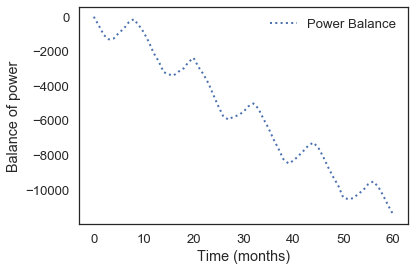

In [15]:
plot(B, ':', label='Power Balance')
decorate(xlabel='Time (months)',
    ylabel='Balance of power')

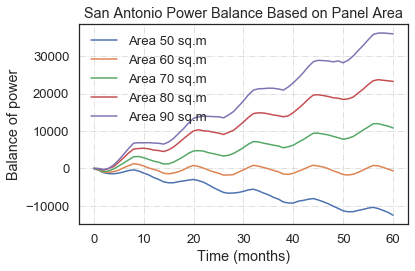

In [16]:
for area in [50,60,70,80,90]:
    system = define_system(A=area, lat=lat, long=long)
    P, N, B = run_simulation(system,update_fxn)
    plt.plot(B, label =f'Area {area} sq.m')
decorate(xlabel='Time (months)',
    ylabel='Balance of power',
    title='San Antonio Power Balance Based on Panel Area')
plt.grid(b=True,alpha = 0.6, linestyle='dashdot')

As we can see, the $60m^2$ panel array just about keeps up with the consumption demand structure we have assumed. 

---

Let's adjust our system to account for the average price of electricity in the state we are looking at as well as the initial cost of installing a solar panel system. We will also expand the duration of the simulation as the median length of home ownership in the US according to one source is [13 years](https://www.nar.realtor/blogs/economists-outlook/how-long-do-homeowners-stay-in-their-homes)

In [17]:
prices = pd.read_csv("Average_US_Electricity_Price.csv", sep = '\t', header = None)
prices.columns = ['State','Avg_Rate_2019','Avg_Rate_2018','%_change','Monthly_cost']
prices.head()

,State,Avg_Rate_2019,Avg_Rate_2018,%_change,Monthly_cost
0,Alaska,21.75,21.52,1.1,$195.10
1,Alabama,11.85,11.51,2.9,$106.29
2,Arkansas,9.30,9.38,-0.9,$83.42
3,Arizona,12.21,12.18,0.2,$109.52
4,California,18.34,19.10,-4.1,$164.51


In [18]:
def define_system2(A,lat,long,state,initial_cost,r = 0.175,PR=0.8):
    '''Create a system object defining our solar panel system
    
    A -    surface area of the panels (in m^2)
    r -    solar panel efficiency (between 15 and 21%, default 17.5%)
    PR -   performance ratio (between 50 and 90%, default 80%
    lat -  latitude of the location
    long - longitude of the location
    
    returns: System object
    '''
    start = State(P=0, N=0, PB=0, FB = -initial_cost, C=0)
    '''Create a state tracking the positive/negative months as well as the balance overall
    P -    number of months where more power was generated than used
    N -    number of months where less power was generated than used
    PB -   overall balance of power
    FB -   overall financial expenditure
    C -    power Consumption
    '''
    t0 = 0
    '''13 years worth of operation'''
    t_end = 13*12
    
    return System(start=start, t0=t0, t_end=t_end, A=A, r=r, PR=PR, state = state, lat=lat, long=long)

We need to also adjust the update_function and run_simulation to account for the cost associated with each kWh. 

In [19]:
def update_fxn2(state,system,month):
    '''Update the pos/neg/balance model.
    
    state: State with variables P, N, PB, FB, C
    system: System with relevant info
    '''
    p, n, pb, fb, c = state
    
    price = prices.loc[prices['State'] == system.state, 'Avg_Rate_2019'].iloc[0]
    price = price/100
    
    month_result = calc_month(system, month)
    
    p += month_result.P
    n += month_result.N
    pb += month_result.B
    fb += month_result.B * price
    c += month_result.C * price
          
    return State(P=int(p), N=int(n), PB=pb, FB = fb, C = c)

In [20]:
def run_simulation2(system,upd_fxn):
    """Take a system as input and unpdate it based on the update function.
    
    system - system object defining panels
    update_fxn - function describing change to system 
    
    returns - Timeseries
    """
    P = TimeSeries()
    N = TimeSeries()
    PB = TimeSeries()
    FB = TimeSeries()
    C = TimeSeries()
    
    state = system.start
    t0 = system.t0
    P[t0], N[t0], PB[t0], FB[t0], C[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = upd_fxn(state,system,t)
        P[t+1], N[t+1], PB[t+1], FB[t+1], C[t+1] = state
    
    return P, N, PB, FB, -C

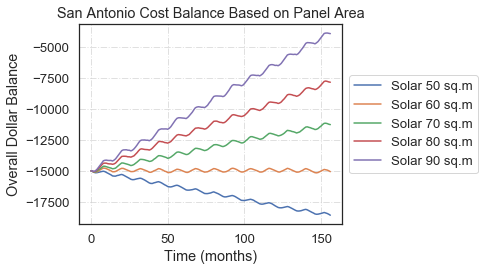

In [21]:
fig = plt.figure()
ax = plt.subplot(111)

for area in [50,60,70,80,90]:
    system = define_system2(A=area, lat=lat, long=long, state='Texas', initial_cost = 15000)
    P, N, PB, FB, C = run_simulation2(system,update_fxn2)
    ax.plot(FB, label = f'Solar {area} sq.m')

decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='San Antonio Cost Balance Based on Panel Area')
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

We can see here that even a $90m^2$ solar panel array with the efficiency and Performance Ratio selected would fail to pay back the initial expenditure of 15,000. But wait, this doesn't account for the money the homeowner would have been paying for electricity had they not acquired the solar panels. Let's overlay a plot of the amount of power consumed multiplied byt th eprice of electricity in the location we slected to how the balance looks in the big picture. 

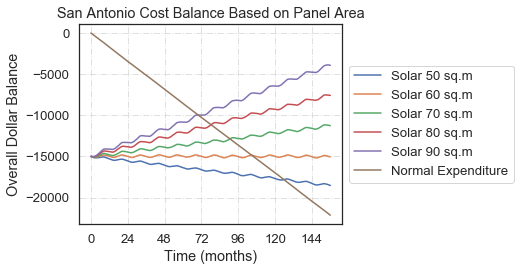

In [22]:
fig = plt.figure()
ax = plt.subplot(111)

for area in [50,60,70,80,90]:
    system = define_system2(A=area, lat=lat, long=long, state='Texas', initial_cost = 15000)
    P, N, PB, FB, C = run_simulation2(system,update_fxn2)
    ax.plot(FB, label = f'Solar {area} sq.m')
ax.plot(C, label = "Normal Expenditure")
decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='San Antonio Cost Balance Based on Panel Area')
ax.set_xticks(np.linspace(0,12*12,7))
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

When accounting for the amount the homeowner would have spent paying for power from the grid, we see a much better picture - all of our models result in a better overall expenditure within 11 years, with the $90m^2$ array paying for itself within 6 years!

---

Let's take a look at how much that number improves with more efficient panels. [SunPower](https://us.sunpower.com/how-many-solar-panels-do-you-need-panel-size-and-output-factors) have some of the [most efficient solar panels](https://news.energysage.com/what-are-the-most-efficient-solar-panels-on-the-market/) with an average efficiency of 20.7%. Let's see how our  models behave with this improved efficiency:

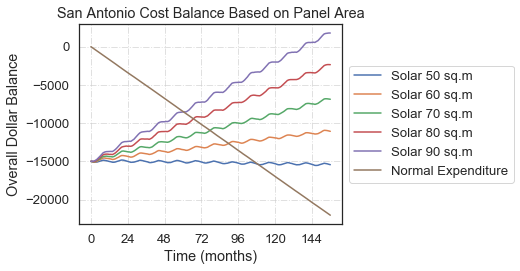

In [23]:
SunPower_r = 0.207
fig = plt.figure()
ax = plt.subplot(111)

for area in [50,60,70,80,90]:
    system = define_system2(A=area, lat=lat, long=long, state='Texas', initial_cost = 15000, r = SunPower_r)
    P, N, PB, FB, C = run_simulation2(system,update_fxn2)
    ax.plot(FB, label = f'Solar {area} sq.m')
ax.plot(C, label = "Normal Expenditure")
decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='San Antonio Cost Balance Based on Panel Area')
ax.set_xticks(np.linspace(0,12*12,7))
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

From the simulation above we can see that the $50m^2$ system of the high-efficiency panels repays itself within about 9 years, whereas the $90m^2$ one only takes 5 years with this improved efficiency. 

---

Alternatively we can see the effect of the efficiency of your panels assuming a fixed surface area (likely limited based on a particular home/roof size). A quick search shows that [average US roof size is 1,700 sq ft](https://www.roofingcalc.com/roof-replacement-cost/#:~:text=The%20average%20residential%20roof%20size,the%203%2Ddimensional%20roof%20surface.), but as only part of a roof is often viable as a surface for panels, let's assume half of that number for a Surface Area of 850 sq ft ~ 80 sq m. For the efficiency range we will look at values between 15 and 21%:

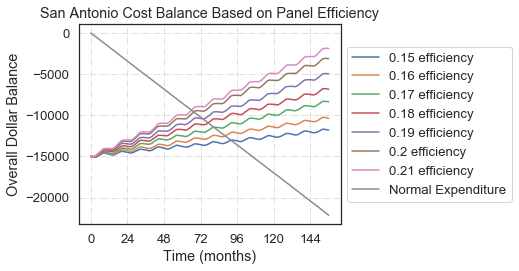

In [24]:
fig = plt.figure()
ax = plt.subplot(111)

for r in [0.15,0.16,0.17, 0.18,0.19,0.2,0.21]:
    system = define_system2(A=80, lat=lat, long=long, state='Texas', initial_cost = 15000, r=r)
    P, N, PB, FB, C = run_simulation2(system,update_fxn2)
    ax.plot(FB, label = f'{r} efficiency')
ax.plot(C, label = "Normal Expenditure")
decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='San Antonio Cost Balance Based on Panel Efficiency')
ax.set_xticks(np.linspace(0,12*12,7))
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

As we can see from the graph above, the efficiency of the panels you purchase can decrease the time before the investment pays for itself by as much as 2 years. 

---

Let's create a function repeating our simulations n number of times and averaging our results, so we can be sure that we are accounting for variation. 

In [66]:
def repeat_sim(n, sim, sys, fxn):
    P, N, PB, FB, C = 0,0,0,0,0
    div = int(n)
    for i in range(0,n):
        p, n, pb, fb, c = sim(sys,fxn)
        P += p
        N += n
        PB += pb
        FB += fb
        C += c
    P = P.divide(other = int(div))
    N = N.divide(other = int(div))
    PB = PB.divide(other = int(div))
    FB = FB.divide(other = int(div))
    C= C.divide(other = int(div))
    return P, N, PB, FB, C
        

In [72]:
system = define_system2(A=80, lat=lat, long=long, state='Texas', initial_cost = 15000)
P, N, PB, FB, C = repeat_sim(10,run_simulation2,system,update_fxn2)

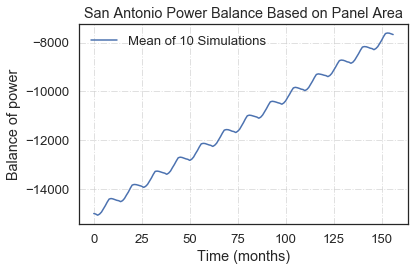

In [77]:
plt.plot(FB, label =f'Mean of 10 Simulations')
decorate(xlabel='Time (months)',
    ylabel='Balance of power',
    title='San Antonio Power Balance Based on Panel Area'),
plt.grid(b=True,alpha = 0.6, linestyle='dashdot')

---

Finally let's create a final simulation that let's you input your details (Panel Area, efficiency, State - for power costs, Initial expenditure) and see what we get. To make it simpler we will assign default values to some of those variables.

In [25]:
def define_system3(A=80,r=0.175,PR=0.8,lat=lat,long=long,state='Texas',initial_cost=15000):
    '''Create a system object defining our solar panel system
    
    A -    surface area of the panels (in m^2)
    r -    solar panel efficiency (between 15 and 21%, default 17.5%)
    PR -   performance ratio (between 50 and 90%, default 75%
    lat -  latitude of the location
    long - longitude of the location
    
    returns: System object
    '''

    start = State(P=0, N=0, PB=0, MP = -initial_cost, C = 0)
    '''Create a state tracking the positive/negative months as well as the balance overall
    P -    number of months where more power was generated than used
    N -    number of months where less power was generated than used
    PB -   overall balance of power
    FB -   overall financial expenditure
    '''
    t0 = 0
    '''13 years worth of operation'''
    t_end = 13*12
    
    return System(start=start, t0=t0, t_end=t_end, A=A, r=r, PR=PR, state = state, lat=lat, long=long)


Text(value='', description='State')

Text(value='', description='Efficiency')

Text(value='', description='Panel Area')

Text(value='', description='Init. Cost')

Button(description='Run Simulation!', style=ButtonStyle())

Texas selected
Efficiency set to 0.19
Panel area set to 75 sq m
Initial investment set to $12000


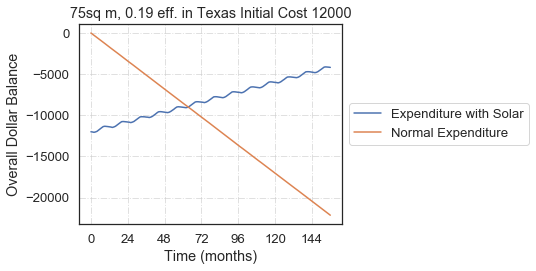

In [79]:
from ipywidgets import widgets
from IPython.display import display
st = widgets.Text(description="State")
ef = widgets.Text(description="Efficiency")
SA = widgets.Text(description="Panel Area")
Cst = widgets.Text(description="Init. Cost")
button = widgets.Button(description="Run Simulation!")

display(st)
display(ef)
display(SA)
display(Cst)
States = list(prices['State'])

def set_eff(r):
    r = r
    return r

def handle_state(sender):
    if st.value in States:
        print(f'{st.value} selected')
    else:
        print("Please enter valid state")

def handle_ef(sender):
    r = float(ef.value)
    if r > 0.14 and r < 0.23:
        print(f'Efficiency set to {r}')
    else:
        print("Please enter valid value for efficiency (0.15 < eff < 0.22)")
        
def handle_SA(sender):
    area = int(SA.value)
    if area > 0:
        print(f'Panel area set to {area} sq m')
    else:
        print("Please enter valid value for panel area in sq m")

        
def handle_Cst(sender):
    cost = int(Cst.value)
    if cost >= 0:
        print(f'Initial investment set to ${cost}')
    else:
        print("Please enter valid value for initial investment")

def Run_Sim(b):
    if ef.value == '':
        r = 0.175
    else:
        r = float(ef.value)
        
    if SA.value == '':
        SArea = 80
    else:
        SArea = int(SA.value)
        
    if st.value == '':
        Stt ='Texas'
    else:
        Stt = st.value
        
    if Cst.value == '':
        COST = 15000
    else:
        COST = int(Cst.value)
    
    
    system = define_system3(r=r, A=SArea, lat=40.71427, long=-74.00597, state=Stt, initial_cost = COST)
    P, N, PB, FB, C = repeat_sim(5,run_simulation2,system,update_fxn2)
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(FB, label = 'Expenditure with Solar')
    ax.plot(C, label = "Normal Expenditure")
    decorate(xlabel='Time (months)',
        ylabel='Overall Dollar Balance',
        title=f'{SArea}sq m, {r} eff. in {Stt} Initial Cost {COST}')
    ax.set_xticks(np.linspace(0,12*12,7))
    ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

display(button)
st.on_submit(handle_state)
ef.on_submit(handle_ef)
SA.on_submit(handle_SA)
Cst.on_submit(handle_Cst)
button.on_click(Run_Sim)

Future Steps:
1. Fix API access - critical for customizable results
2. Add a power demand function that takes user input (household size, # bedrooms, or avg use)
3. Add the opportunity for panels breaking and repair costs